**[David Davó Laviña](https://ddavo.me/es) y Leidy Vanesa Vidales González**
# Valoración de Opciones Europeas usando Computación Cuántica

Antes de continuar, recomendamos leer la memoria del proyecto disponible en [GitHub](https://github.com/Irulam/trading-cuantitativo-cuantico), que contiene una introducción a las finanzas, al igual que a distintos métodos clásicos de valoración de opciones. Además, será referenciada a lo largo de este Notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as ipw

from qiskit import Aer, QuantumCircuit
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import LogNormalDistribution, LinearAmplitudeFunction

Además de importar las librerías de siempre de Qiskit, vamos a usar la librería Qiskit [Aqua](https://qiskit.org/documentation/apidoc/qiskit_aqua.html) que contiene implementaciones de distintos algoritmos, como el de estimación de amplitud que usaremos. También cuenta con un módulo `qiskit.aqua.finance` con algorítmos específicos para finanzas.

También usaremos la librería de circuitos pre-implementados de Qiskit, para simular una distribución log-normal en los qubits de nuestro circuito.

## Opciones de compra (calls)
Como hemos podido ver en la memoria, dado $V$ el valor del subyacente en la fecha de vencimiento y $E$ el precio de ejercicio, la función de pago de una función de compra será:
$$ \max\left(V-E,0\right) $$

Al igual que con el método de Montecarlo, generaremos una distribución de probabilidad $\mathbb{P}$, que concretamente seguirá una distribución log-normal. Nuestro **objetivo** será obtener aproximadamente el valor esperado de la función de pago para la distribución, pero en un tiempo mucho más eficiente que con Montecarlo. Para ello, nos apoyaremos en la estimación de la amplitud:

$$ \hat{\mathbb{E}}_{\mathbb{P}}\left[\max\left(V-E,0\right)\right] $$

También nos interesará obtener $\Delta$, la función que nos define la distribución de probabilidad del precio de la opción:

$$ \Delta = \mathbb{P}\left[V\geq E\right] $$

### Modelo de incertidumbre
Vamos a ver lo que hace el circuito `LogNormalDistribution`. Dados $n$ qubits retorna la codificación en el dominio de la fase de la distribución log-normal discretizada en $2^n$ puntos (todos los posibles con $n$ qubits). Es decir, siendo $p_i$ el punto $i$ de la distribución de probabilidad discretizada, el circuito realiza la siguiente función matemática:

$$ |0\rangle_n \mapsto |\psi\rangle_n = \sum_{i=0}^{2^n-1} \sqrt{p_i}|i\rangle_n $$

El problema es que requiere de una cantidad de puertas cuánticas insasumible.

Para solucionar este problema se usa una red neuronal implementada mediante un circuito cuántico denominada generative adversarial network (GAN) que interpreta la distribución como un estado cuántico.

Así, con tan solo $n$ qubits, ¡tenemos codificados $2^n$ puntos de la distribución lognormal!

Siguiendo el modelo Black-Scholes-Merton, podemos crear nuestra distribución log-normal con los parámetros:

$$ \mu = (r-0.5\sigma^2)T+\ln\left(S_0\right) $$

Donde $\sigma$ es la volatilidad (que en el modelo Black-Scholes-Merton considera constante), $r$ es el interés de mercado, $T$ es el tiempo que pasa hasta la fecha de vencimiento y $S_0$ es el precio del activo con $t=0$.

Para ser más precisos en la discretización, el algoritmo nos permite establecer el rango de valores entre los que discretizaremos, elegiremos el rango en el que los datos no se desvían más de 3 veces la desviación típica de la media.

Vamos a realizar un ejemplo, donde el precio inicial de la acción es $2€$, la volatilidad es de 0.4, y su interés anual es del 5%, queremos calcular la distribución de valores de dicha acción tras 40 días.

In [23]:
def modelo_incertidumbre(
        qubits=3, 
        spot_price=2.0, # Precio actual
        volatilidad=0.4,
        interes_anual=0.05,
        maduracion= 40 / 365 # Tiempo hasta la fecha de vencimiento en años):
    ):
    
    mu = ((interes_anual - 0.5 * volatilidad**2) * maduracion + np.log(spot_price))
    sigma = volatilidad * np.sqrt(maduracion)
    media = np.exp(mu + sigma**2/2)
    varianza = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
    stddev = np.sqrt(varianza)

    # La discretización nos permite establecer unos límites
    bajo  = np.maximum(0, media - 3*stddev)
    alto = media + 3*stddev

    ret = LogNormalDistribution(qubits, mu=mu, sigma=sigma**2, bounds=(bajo, alto))
    return ret,(bajo,alto)

In [81]:
def plot_modelo_incertidumbre(qubits,spot_price,volatilidad,interes_anual,maduracion_dias):
    mi,bounds = modelo_incertidumbre(qubits,spot_price,volatilidad,interes_anual,maduracion_dias/365)
    x = mi.values
    y = mi.probabilities
    plt.bar(x, y, width=0.2)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.grid()
    plt.xlabel(f'Valor de la acción tras {maduracion_dias} días (€)', size=15)
    plt.ylabel('Probabilidad ($\%$)', size=15)
    plt.show()
    
    return mi,bounds
    
w = ipw.interactive(plot_modelo_incertidumbre, 
             qubits=ipw.IntSlider(min=1,max=7,step=1,value=3, continuous_update=False),
             spot_price=ipw.FloatSlider(min=1.0,max=10.0,value=2.0, continuous_update=False),
             volatilidad=ipw.FloatSlider(min=0.1,max=1.0,value=0.4, continuous_update=False),
             interes_anual=ipw.FloatSlider(min=0.0,max=1.0,value=0.05, continuous_update=False),
             maduracion_dias=ipw.IntSlider(min=5,max=365,value=40, continuous_update=False)
            )
w

interactive(children=(IntSlider(value=3, continuous_update=False, description='qubits', max=7, min=1), FloatSl…

### Algoritmo de estimación de la amplitud
En la computación cuántica se consigue una mejora de la eficiencia respecto a los modelos clásicos con el algoritmo de Estimación de la amplitud.

Para un operador $\mathcal{A}$ que actúe en un registro de n+1 qubits tal que $\mathcal{A}|0\rangle_{n+1}=\sqrt{1-a}|\psi_0\rangle_n|0\rangle + \sqrt{a} |\psi_1\rangle|1\rangle$ donde $|\psi_0\rangle_n$ y $|\psi_0\rangle_n$ son estados normalizados y a pertenece a $[0,1]$. La estimación de amplitud estima el valor de a, que es la probabilidad de medir un $|1\rangle$. Esto lo hace con el operador $\mathcal{Q} = \mathcal{A}\mathcal{S}_0\mathcal{A}^\dagger\mathcal{S}_{\psi_0}$. Donde $S_0$ y $S_{\psi_0}$ son rotaciones, el algoritmo usa una estimación de fase (Quantum Phase Estimation) para conocer la fase de $\mathcal{Q}$ y la mapea a un estimador para $a$.  

Aunque es posible no usar la estimación de fase sabiendo que

$$ 
\mathcal{Q}^k\mathcal{A}|0\rangle_n|0\rangle 
= \cos\left(\left(2k+1\right)\theta_a\right)|\psi_0\rangle_n|0\rangle
+ \sin\left(\left(2k+1\right)\theta_a\right)|\psi_1\rangle_n|1\rangle
$$

### Implementación de  la función payoff 
Pero el valor de la acción sólo nos interesa cuando el payoff es mayor que el strike price, pues es cuando la función de pago retorna algún beneficio.

Como interesa considerar funciones lineales $f$ para cada qubit. Se usa un operador $\mathcal{A}$ tal que $a = \mathbb{E} [f(X)]$ donde $X$ es una variable aleatoria discretizada.(E es la esperanza matemática).

Se crea un operador que haga 

$$ |i\rangle_n|0\rangle \mapsto |i\rangle_n \left(\cos\left[f(i)\right]|0\rangle+\sin\left[f(i)\right]|1\rangle\right) $$

implementado mediante rotaciones Y controladas. 



In [98]:
def create_laf(mi,qubits,bajo,alto,c_approx=0.25):
    # setup piecewise linear objective fcuntion
    breakpoints = [bajo, precio_vencimiento]
    slopes = [0, 1]
    offsets = [0, 0]
    f_min = 0
    f_max = alto - precio_vencimiento
    european_call_objective = LinearAmplitudeFunction(
        qubits,
        slopes,
        offsets,
        domain=(bajo, alto),
        image=(f_min, f_max),
        breakpoints=breakpoints,
        rescaling_factor=c_approx
    )

    num_qubits = european_call_objective.num_qubits
    european_call = QuantumCircuit(num_qubits) 
    european_call.append(mi, range(qubits))
    european_call.append(european_call_objective, range(num_qubits))

    return european_call

def display_laf(c_approx):
    mi = w.result[0]
    precio_vencimiento = mi.values[np.argmax(mi.probabilities)]
    bajo,alto = w.result[1]
    qubits = w.children[0].value
    print(f"Spot price: {precio_vencimiento}")
    c = create_laf(mi,qubits,bajo,alto,c_approx)
    display(c.draw('mpl'))
    
    x = mi.values
    y = np.maximum(0, x - precio_vencimiento)
    plt.plot(x, y, 'ro-')
    plt.grid()
    plt.title('Función de pago', size=15)
    plt.xlabel('Precio del activo', size=15)
    plt.ylabel('Pago', size=15)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.show()
    
    exact_value = np.dot(mi.probabilities, y)
    exact_delta = sum(mi.probabilities[x >= precio_vencimiento])
    print('exact expected value:\t%.4f' % exact_value)
    print('exact delta value:   \t%.4f' % exact_delta)
    
    return c

w_approx = ipw.interactive(display_laf,
                            c_approx=ipw.FloatSlider(min=0.1,max=0.5,value=0.25,step=0.05,continuous_update=False))
w_approx

interactive(children=(FloatSlider(value=0.25, continuous_update=False, description='c_approx', max=0.5, min=0.…

### Evaluación del payoff esperado

Se compara el valor a partir del cual empieza a ser rentable la inversión del modelo con el del circuito que aplica la estimación de amplitud. En primer lugar usando el circuito implementado paso a paso para después compararlo con el circuito de la función del modulo finance de qiskit "EuropeanCallExpectedValue" para comprobar la precisión de ambos circuitos.

In [123]:
from math import pow

def construct_ae(epsilon=0.01,alpha=0.05):
    # construct amplitude estimation
    if epsilon >= 1:
        epsilon = pow(10,-epsilon)
        
    print('Epsilon:            \t%.4f' % epsilon)
    ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                      state_preparation=european_call,
                                      objective_qubits=[3],
                                      post_processing=european_call_objective.post_processing)
    result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

    conf_int = np.array(result['confidence_interval'])
    print('Exact value:        \t%.4f' % exact_value)
    print('Estimated value:    \t%.4f' % (result['estimation']))
    print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))
    
    return ae

w_ae = ipw.interactive(construct_ae, 
                       epsilon=ipw.FloatSlider(value=1,min=1,max=3,continuous_update=False),
                       alpha=ipw.FloatSlider(value=0.05,min=0.025,max=0.30,step=0.025,continuous_update=False)
                      )
w_ae

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='epsilon', max=3.0, min=1.0)…

A continuación se hará la comparación con el circuito del módulo finance. 

In [125]:
from qiskit.finance.applications import EuropeanCallExpectedValue

#Evalúa la opción call según el modelo proporcionado
european_call_objective = EuropeanCallExpectedValue(qubits,
                                                    precio_vencimiento,
                                                    rescaling_factor=c_approx,
                                                    bounds=(bajo, alto))

european_cal1 = european_call_objective.compose(mi, front=True)

epsilon = 0.01
alpha = 0.05

ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_cal1,
                                  objective_qubits=[3],
                                  post_processing=european_call_objective.post_processing)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [126]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.1620
Estimated value:    	0.1709
Confidence interval:	[0.1661, 0.1757]


Tras varias ejecuciones hemos observado que ambos circuitos parecen funcionar con la misma precisión y nos dan resultados parecidos.

In [127]:
from qiskit.finance.applications import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(qubits, precio_vencimiento, bounds=(bajo, alto))

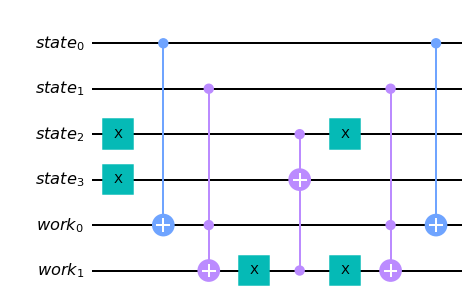

In [128]:
european_call_delta.decompose().draw(output='mpl')

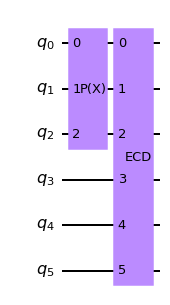

In [130]:
state_preparation = QuantumCircuit(european_call_delta.num_qubits)
state_preparation.append(mi, range(mi.num_qubits))
state_preparation.append(european_call_delta, range(european_call_delta.num_qubits))
state_preparation.draw(output='mpl')

In [131]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                        state_preparation=state_preparation,
                                        objective_qubits=[qubits])

In [132]:
result_delta = ae_delta.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [133]:
conf_int = np.array(result_delta['confidence_interval'])
print('Exact delta:    \t%.4f' % exact_delta)
print('Esimated value: \t%.4f' % result_delta['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Exact delta:    	0.8098
Esimated value: 	0.8090
Confidence interval: 	[0.8043, 0.8137]
